# Computational Psycholinguistics - Assignment 2
By Daan Brugmans

This assignment is an investigation into the ability for Recurrent Neural Networks to predict the P600 ERP Component.
The P600 Component is a peak in brain activity that is measured using EEG and is thought to relate to the human language system, specifically in the processing of syntax errors.
Recent work by [Fitz & Chang (2019)](https://www.sciencedirect.com/science/article/pii/S0010028518300124) and [Frank (2024)](osf.io/preprints/psyarxiv/cx3h6) propose that the P600 Component may be the backpropagation of language error in the brain.
Since Recurrent Neural Networks trained on language data also backpropagate their prediction errors using gradients, there may exist similarities between the language error backpropagation of human and artificial neural language systems.
This notebook is an investigation into these potential similarities.
We will investigate the relation between the gradients and surprisal values of trained RNNs of increasing size and the results from a controlled experiment measuring P600 activity.

## Imports
We import required libraries and code provided by the lecturer of the course in `get_predictions.py`.

In [36]:
from get_predictions import get_predictions

import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import scipy.io
import torch

## Setup
We set a global seed to improve reproducibility of our results.
We also set some constants required for the lecturer's code to work.

In [39]:
def set_global_seed(seed):
    """Sets the same seed for varying libraries."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
SAVED_IMAGES_PATH = os.path.join(Path(os.getcwd()).parent, "report", "images")

VIOLATION_DATA_FILE_PATH = os.path.join(os.getcwd(), "data", "violations.txt")
CONTROL_DATA_FILE_PATH = os.path.join(os.getcwd(), "data", "control.txt")

VIOLATION_ITEMS_FILE_PATH = os.path.join(os.getcwd(), "items", "violations.txt")
CONTROL_ITEMS_FILE_PATH = os.path.join(os.getcwd(), "items", "control.txt")

ITEM_SETS = ["violations", "control"]
LANGUAGE = "en"
CUDA = True

set_global_seed(3131)

## Preparing the Plain Text Stimuli Files
The code provided by the lecturer automatically calculates surprisal and gradients of the RNNs on a text file of sentences.
We use the sentence data from the controlled experiment to automatically prepare a plain text file that fulfills the requirements set by the lecturer's code.
Fortunately, the data from the controlled experiment is almost fully prepared already: sentences end after the critical word (critical verb) and they contain no periods.
We only have to lowercase the sentences and separate the genitive marker from words ("'s").

This prepared files can be found in `./items/violations.txt` and `./items/control.txt`.
`control.txt` contains sentences that are syntactically and semantically correct, and `violations.txt` contains sentences that can be either syntactically or semantically correct, depending upon how the reader interprets them.
In the controlled experiment, participants' P600 is read while they read sentences that are syntactically unambiguous, but would be semantically illogical, which is done by reversing roles of agents in the sentence (e.g. "*The hearty meal was devouring the kids.*" instead of "*The kids were devouring the hearty meal.*").
Traditionally, the P600 was interpreted to only process syntactic error, while the N400 processed semantic error.
With this experiment, the researches measure both the P600 and N400 in participants while reading sentences such as the one above, and they showed that it was a P600 effect that was solicited by such sentences instead of an N400.
Since the researches show that the P600 can still be activated in syntactically unambiguous sentences, they showed that the P600 likely did not purely account for syntactic error, which was a common view of the P600 at the time.

In [18]:
for stimuli_data_path, stimuli_items_path in zip([VIOLATION_DATA_FILE_PATH, CONTROL_DATA_FILE_PATH], [VIOLATION_ITEMS_FILE_PATH, CONTROL_ITEMS_FILE_PATH]):
    with open(stimuli_data_path, "r") as stimuli_data:
        lowered_stimuli_text = stimuli_data.read().lower().replace("'s", " 's")
        
    with open(stimuli_items_path, "w") as stimuli_items:
        stimuli_items.write(lowered_stimuli_text)

## Generating the Model Surprisal Values
We generate the surprisal values of the various models on the sentence data from both `violations.txt` and `control.txt` from the study using `get_predictions.py`

In [19]:
get_predictions(ITEM_SETS, LANGUAGE, "surp", CUDA)

surprisal_violations_df = pd.read_csv("./predictions/surp_violations.csv", sep="\t")
del surprisal_violations_df["Unnamed: 0"]

surprisal_control_df = pd.read_csv("./predictions/surp_control.csv", sep="\t")
del surprisal_control_df["Unnamed: 0"]

surprisal_violations_df

violations
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_10000
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_30000
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_100000
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_300000
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_1000000
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_3000000
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_10000000
C:/Users/Daan/Documents/Projecten/ru-computational-psych

,sent_nr,word_pos,item,surp_10000,surp_30000,surp_100000,surp_300000,surp_1000000,surp_3000000,surp_10000000,surp_30000000,surp_epoch1
0,1,1,101,4.988979,3.297280,2.863694,2.981160,3.722783,4.435917,4.082286,4.023783,4.405149
1,1,2,102,10.268595,11.058625,11.183846,10.647034,9.395885,9.686049,8.921486,8.548016,8.948655
2,1,3,103,6.604028,6.369899,5.802369,5.635458,5.216017,5.997865,5.770838,7.054215,6.766899
3,1,4,104,6.517825,6.106529,6.304446,5.866919,2.251942,1.940566,1.653590,1.347556,1.454811
4,1,5,105,10.871460,11.720407,12.525619,12.515888,11.708185,10.544847,10.520592,12.609795,12.512777
...,...,...,...,...,...,...,...,...,...,...,...,...
572,96,2,9602,10.059324,9.922897,9.898547,9.535522,9.256714,9.419758,9.543768,9.299114,9.435221
573,96,3,9603,10.577240,11.038630,10.822658,10.371534,9.735857,9.012733,6.743614,6.865142,7.585968
574,96,4,9604,6.436663,6.355276,5.982605,5.840961,5.760174,7.297630,6.971642,7.577765,8.182822
575,96,5,9605,6.440657,6.102928,6.397666,5.978615,2.043166,2.198362,2.056237,1.803331,1.851205


## Generating the Model Gradients
We generate the gradient values of the various models on the sentence data from both `violations.txt` and `control.txt` from the study using `get_predictions.py`

In [20]:
get_predictions(ITEM_SETS, LANGUAGE, "grad", CUDA)

gradient_violations_df = pd.read_csv("./predictions/grad_violations.csv", sep="\t")
del gradient_violations_df["Unnamed: 0"]

gradient_control_df = pd.read_csv("./predictions/grad_control.csv", sep="\t")
del gradient_control_df["Unnamed: 0"]

gradient_violations_df

violations
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_10000
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_30000
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_100000
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_300000
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_1000000
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_3000000
C:/Users/Daan/Documents/Projecten/ru-computational-psycholinguistics-23-24/assignment-2/code/trained_models/nwp_model_lstm_en_10000000
C:/Users/Daan/Documents/Projecten/ru-computational-psych

,sent_nr,word_pos,item,grad_10000,grad_30000,grad_100000,grad_300000,grad_1000000,grad_3000000,grad_10000000,grad_30000000,grad_epoch1
0,1,1,101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,102,37.307022,52.399727,41.994957,55.547485,49.503536,240.494995,724.104736,1216.094727,1317.139404
2,1,3,103,108.487762,50.015877,147.486710,246.617920,2191.590332,3719.921875,3229.023193,3679.766113,3446.966309
3,1,4,104,119.396973,65.139351,189.717499,317.800659,2065.599854,2603.927979,2655.846924,1604.444458,1569.668335
4,1,5,105,197.917679,100.232574,106.848328,206.499924,535.162476,902.719055,2671.541260,3559.816162,3690.327393
...,...,...,...,...,...,...,...,...,...,...,...,...
572,96,2,9602,31.855768,33.471645,31.506760,38.604443,98.165436,395.449310,866.863403,1088.300903,1226.023804
573,96,3,9603,104.238625,65.614799,58.055080,90.621124,1148.674194,1030.510986,1892.186768,2139.515381,2534.400146
574,96,4,9604,128.117950,66.272034,244.207565,403.969360,3646.045166,5688.530762,4474.561035,4069.069580,3558.191650
575,96,5,9605,130.734268,76.031342,264.305176,447.273865,2054.170166,3261.729248,3141.850342,2266.585938,1831.640747


## Visualizing Correlations between Data
We define a function called `draw_lineplot`.
This function draws a scatterplot of the two provided vectors in addition to calculating and drawing a quadratic function fit to the data and the Pearson Correlation Coefficient (r) between the variables.

We merge the dataframes of the model surprisal data and model gradients data into one dataframe.
As is standard in the analysis of data regarding human reading, we remove the first word of every sentence from the data.
We also remove sentences for which no gradients or suprisals were calculated.

In [52]:
def draw_lineplot(x_axis_name: str, y_axis_name: str, df: pd.DataFrame, x_axis_label: str = None, y_axis_label: str = None, title: str = None):   
    # Draw a linear regression plot, a scatter plot with a linear regression line on top of it
    plt.figure()
    plot = sns.lmplot(x=x_axis_name, y=y_axis_name, data=df, seed=3131, line_kws={"color": "C1"}, order=2)
    
    if (x_axis_label is not None) and (y_axis_label is not None):
        plot.set_axis_labels(x_axis_label, y_axis_label)
    
    if title is not None:
        plt.title(title)
    
    # Iterate over the data points in the plot
    for _, facet_df in plot.facet_data():
        # Remove missing values when calculating the linear regression
        facet_df = facet_df.dropna(axis=0)
        
        # Calculate slope, intercept, and correlation coefficient r of the linear regression shown in the plot
        _, _, r, _, _ = scipy.stats.linregress(
            x=facet_df[x_axis_name],
            y=facet_df[y_axis_name]
        )
                
        # Write the regression's formula onto the plot
        max_x = facet_df[x_axis_name].max(axis=0)
        max_y = facet_df[y_axis_name].max(axis=0)
        
        plt.text(max_x * 0.7, max_y * 0.95, f"r = {round(r, 3)}")
    
    return r


# Merging the model stimuli dataframes with each other
violations_df = pd.merge(surprisal_violations_df, gradient_violations_df.iloc[:, 2:], on="item")
control_df = pd.merge(surprisal_control_df, gradient_control_df.iloc[:, 2:], on="item")

# Removing sentence-initial words
violations_df = violations_df[~(violations_df["word_pos"] == 1)]
control_df = control_df[~(control_df["word_pos"] == 1)]

# Remove empty rows
violations_df = violations_df.dropna(axis=0, how="any")
control_df = control_df.dropna(axis=0, how="any")

violations_df

,sent_nr,word_pos,item,surp_10000,surp_30000,surp_100000,surp_300000,surp_1000000,surp_3000000,surp_10000000,...,surp_epoch1,grad_10000,grad_30000,grad_100000,grad_300000,grad_1000000,grad_3000000,grad_10000000,grad_30000000,grad_epoch1
1,1,2,102,10.268595,11.058625,11.183846,10.647034,9.395885,9.686049,8.921486,...,8.948655,37.307022,52.399727,41.994957,55.547485,49.503536,240.494995,724.104736,1216.094727,1317.139404
2,1,3,103,6.604028,6.369899,5.802369,5.635458,5.216017,5.997865,5.770838,...,6.766899,108.487762,50.015877,147.486710,246.617920,2191.590332,3719.921875,3229.023193,3679.766113,3446.966309
3,1,4,104,6.517825,6.106529,6.304446,5.866919,2.251942,1.940566,1.653590,...,1.454811,119.396973,65.139351,189.717499,317.800659,2065.599854,2603.927979,2655.846924,1604.444458,1569.668335
4,1,5,105,10.804787,11.546673,11.548120,11.378952,10.311533,8.964034,9.113940,...,7.407097,189.567337,92.914040,95.975868,176.435242,511.660919,1261.726318,2598.531494,2504.318604,2642.541504
25,5,2,502,9.796881,8.862782,8.919074,9.063160,7.876539,7.809708,8.527226,...,7.934144,25.742819,31.769707,44.224014,62.701653,72.579308,370.630737,769.764587,1094.725342,1085.881104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,96,2,9602,10.059324,9.922897,9.898547,9.535522,9.256714,9.419758,9.543768,...,9.435221,31.855768,33.471645,31.506760,38.604443,98.165436,395.449310,866.863403,1088.300903,1226.023804
573,96,3,9603,10.577240,11.038630,10.822658,10.371534,9.735857,9.012733,6.743614,...,7.585968,104.238625,65.614799,58.055080,90.621124,1148.674194,1030.510986,1892.186768,2139.515381,2534.400146
574,96,4,9604,6.436663,6.355276,5.982605,5.840961,5.760174,7.297630,6.971642,...,8.182822,128.117950,66.272034,244.207565,403.969360,3646.045166,5688.530762,4474.561035,4069.069580,3558.191650
575,96,5,9605,6.440657,6.102928,6.397666,5.978615,2.043166,2.198362,2.056237,...,1.851205,130.734268,76.031342,264.305176,447.273865,2054.170166,3261.729248,3141.850342,2266.585938,1831.640747


### Visualizing Correlations between Surprisal and Gradients for Violation Sentences
We draw plots of a model's surprisal values versus its gradient values for every model size, then draw a final plot to show the change in Pearson Correlation Coefficient between the variables as the model grows in size.

<Figure size 600x600 with 0 Axes>

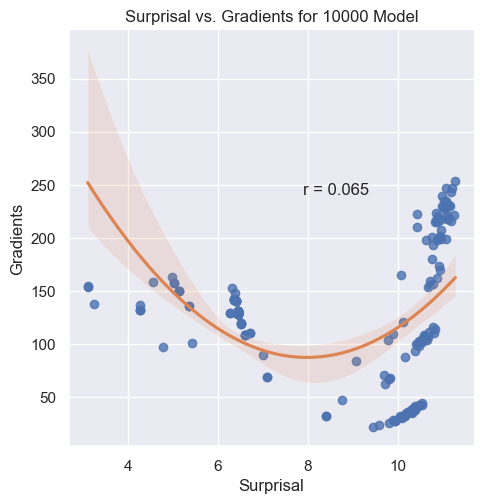

<Figure size 600x600 with 0 Axes>

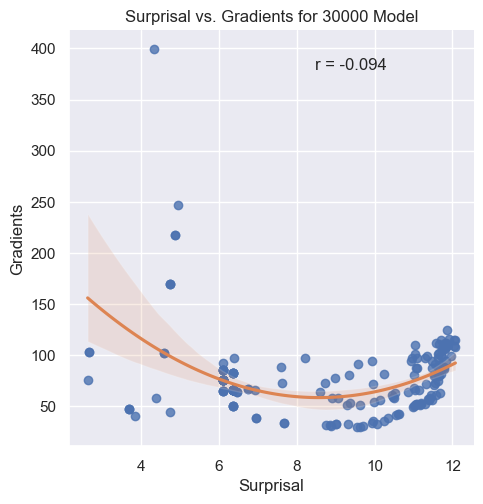

<Figure size 600x600 with 0 Axes>

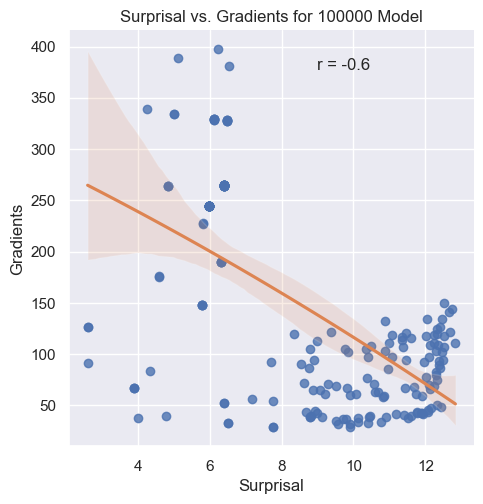

<Figure size 600x600 with 0 Axes>

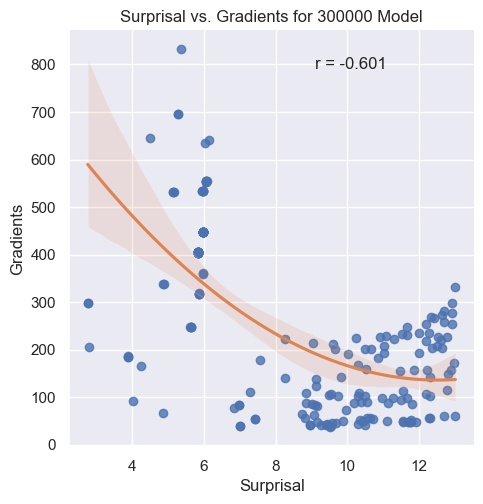

<Figure size 600x600 with 0 Axes>

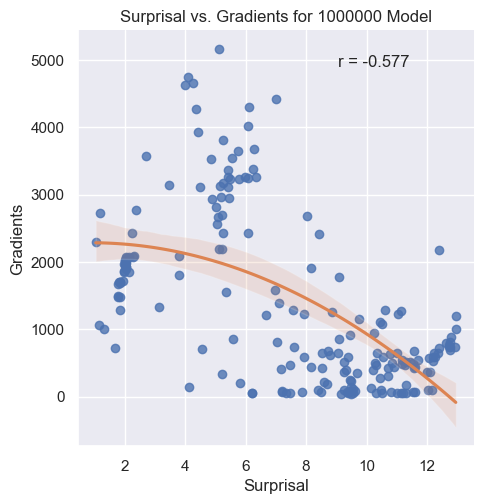

<Figure size 600x600 with 0 Axes>

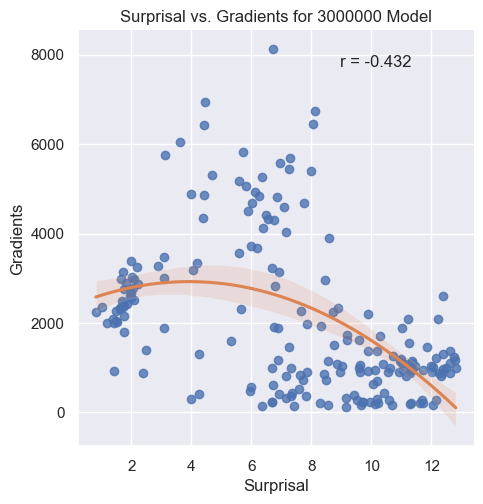

<Figure size 600x600 with 0 Axes>

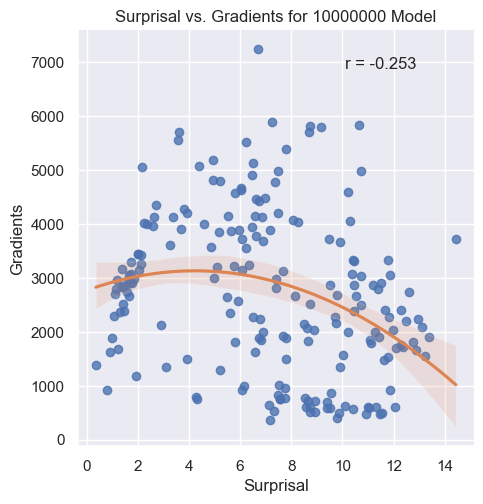

<Figure size 600x600 with 0 Axes>

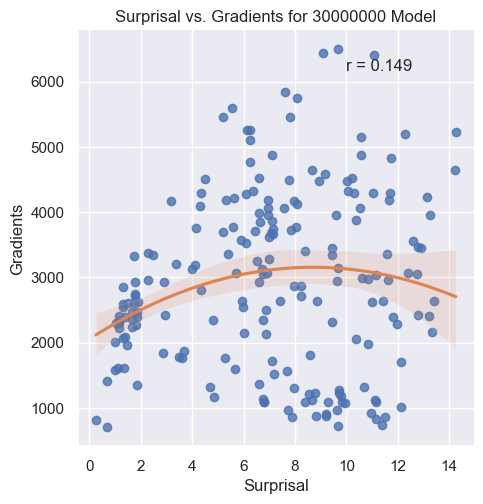

<Figure size 600x600 with 0 Axes>

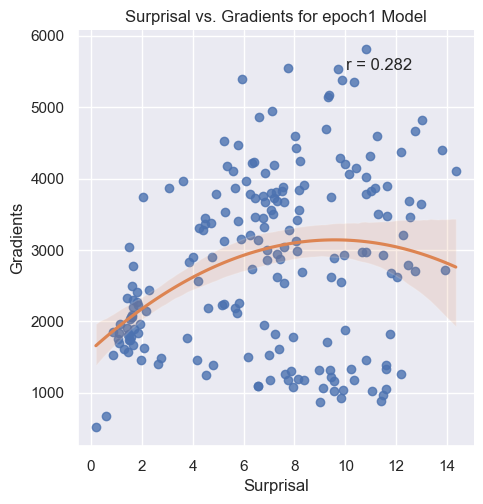

In [47]:
# Setting size of the plots 
sns.set_theme(rc={'figure.figsize':(6, 6)})

# Finding the columns with results of different model sizes
model_column_names_mask = violations_df.columns.str.contains("surp_*")
surpisal_columns_names = violations_df.loc[:, model_column_names_mask]

regression_data_df = []
# For every model size, visualize the correlation between its surprisal values and gradient values
for column_name in surpisal_columns_names.columns:
    model_size_string = column_name[5:]
    
    r_correlation = draw_lineplot(
        x_axis_name=f"surp_{model_size_string}", 
        y_axis_name=f"grad_{model_size_string}", 
        df=violations_df,
        x_axis_label="Surprisal",
        y_axis_label="Gradients",
        title=f"Surprisal vs. Gradients for {model_size_string} Model"
    )
    
    plt.savefig(os.path.join(SAVED_IMAGES_PATH, "violations_surprisal_vs_gradients", f"{model_size_string}.png"), bbox_inches="tight")
    
    regression_data_df.append([model_size_string, r_correlation])

,Model Size,Pearson Correlation Coefficient (r)
0,10000,0.065307
1,30000,-0.094488
2,100000,-0.600288
3,300000,-0.600557
4,1000000,-0.577191
5,3000000,-0.431652
6,10000000,-0.252859
7,30000000,0.149474
8,epoch1,0.282124


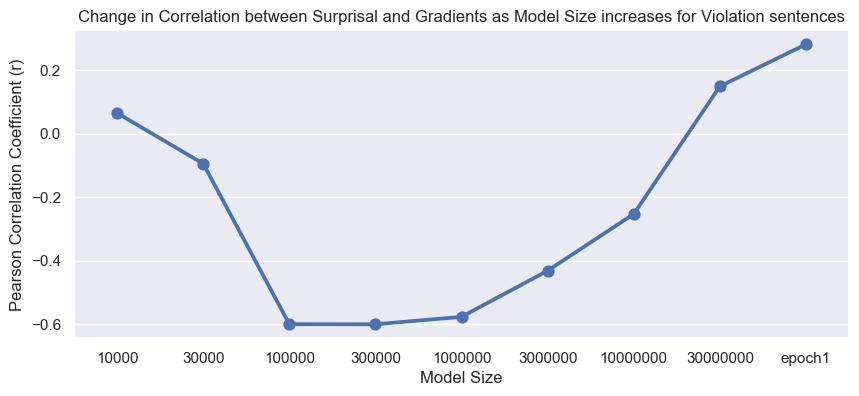

In [48]:
# Change plot size to display x-axis ticks more legible
sns.set_theme(rc={'figure.figsize':(10, 4)})

regression_data_df = pd.DataFrame(regression_data_df, columns=["Model Size", "Pearson Correlation Coefficient (r)"])

plt.figure()
sns.pointplot(data=regression_data_df, x="Model Size", y="Pearson Correlation Coefficient (r)")
plt.title("Change in Correlation between Surprisal and Gradients as Model Size increases for Violation sentences")
regression_data_df

### Visualizing Correlations between Surprisal and Gradients for Control Sentences
We draw plots of a model's surprisal values versus its gradient values for every model size, then draw a final plot to show the change in Pearson Correlation Coefficient between the variables as the model grows in size.

<Figure size 600x600 with 0 Axes>

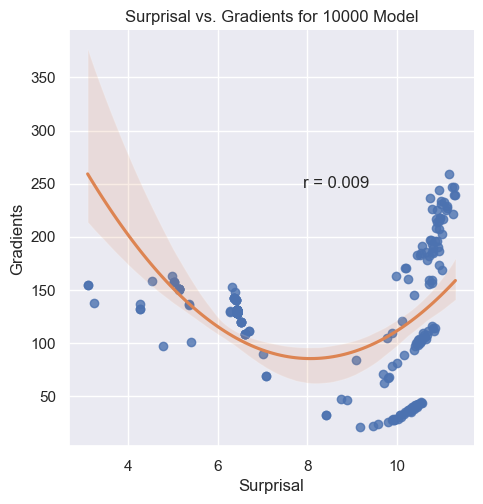

<Figure size 600x600 with 0 Axes>

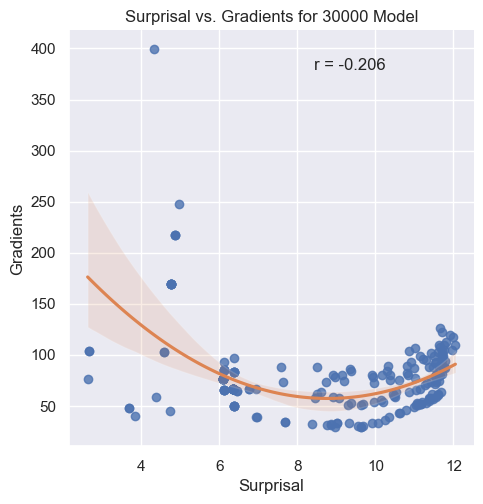

<Figure size 600x600 with 0 Axes>

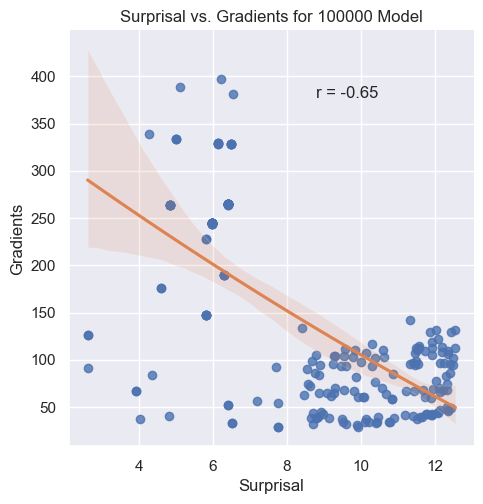

<Figure size 600x600 with 0 Axes>

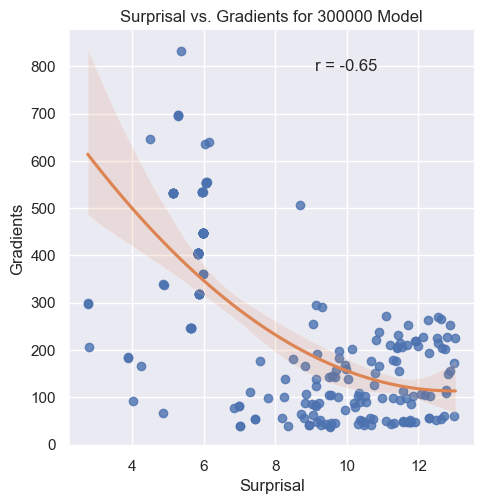

<Figure size 600x600 with 0 Axes>

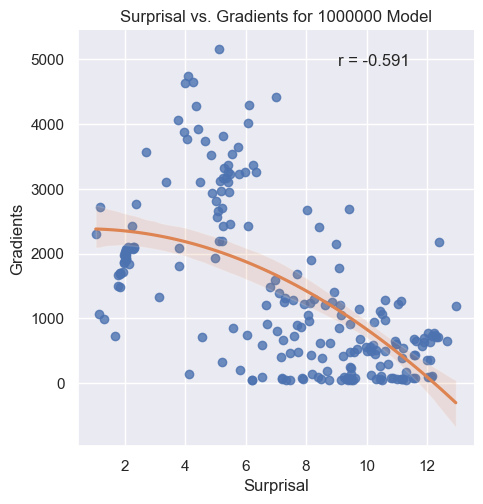

<Figure size 600x600 with 0 Axes>

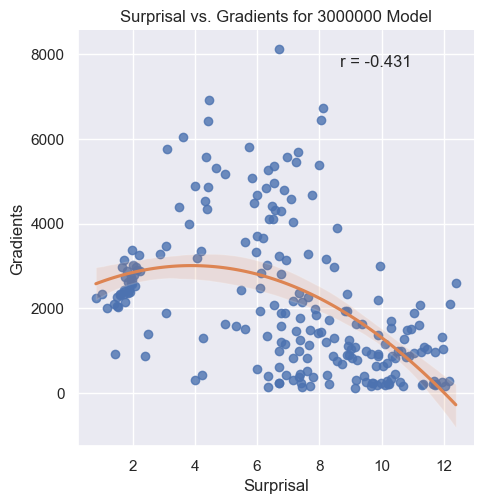

<Figure size 600x600 with 0 Axes>

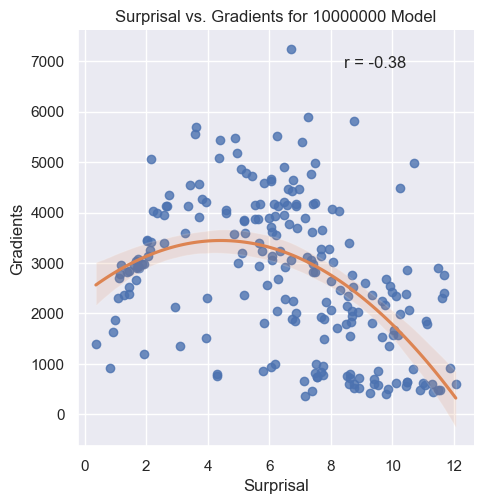

<Figure size 600x600 with 0 Axes>

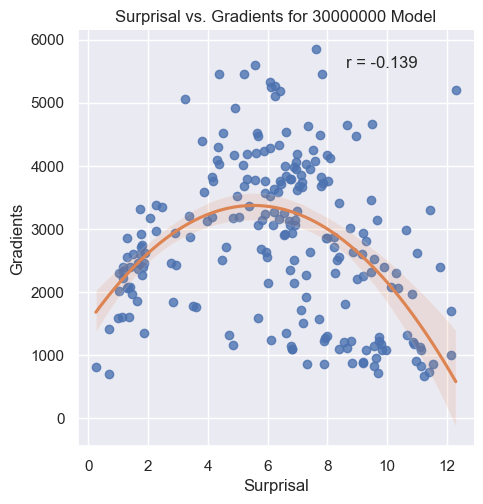

<Figure size 600x600 with 0 Axes>

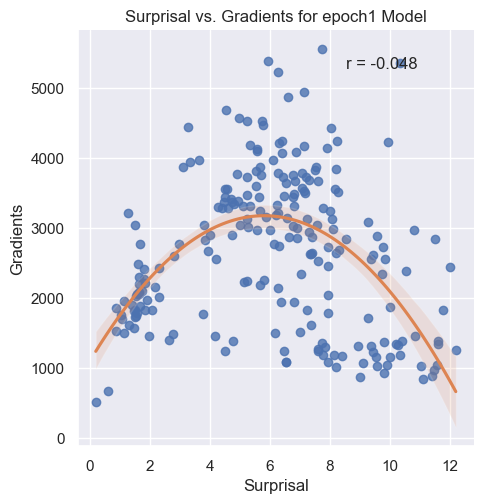

In [49]:
# Setting size of the plots 
sns.set_theme(rc={'figure.figsize':(6, 6)})

# Finding the columns with results of different model sizes
model_column_names_mask = control_df.columns.str.contains("surp_*")
surpisal_columns_names = control_df.loc[:, model_column_names_mask]

regression_data_df = []
# For every model size, visualize the correlation between its surprisal values and gradient values
for column_name in surpisal_columns_names.columns:
    model_size_string = column_name[5:]
    
    r_correlation = draw_lineplot(
        x_axis_name=f"surp_{model_size_string}", 
        y_axis_name=f"grad_{model_size_string}", 
        df=control_df,
        x_axis_label="Surprisal",
        y_axis_label="Gradients",
        title=f"Surprisal vs. Gradients for {model_size_string} Model"
    )
    
    plt.savefig(os.path.join(SAVED_IMAGES_PATH, "control_surprisal_vs_gradients", f"{model_size_string}.png"), bbox_inches="tight")
    
    regression_data_df.append([model_size_string, r_correlation])

,Model Size,Pearson Correlation Coefficient (r)
0,10000,0.009104
1,30000,-0.205665
2,100000,-0.649827
3,300000,-0.649755
4,1000000,-0.590534
5,3000000,-0.431416
6,10000000,-0.379585
7,30000000,-0.138755
8,epoch1,-0.048008


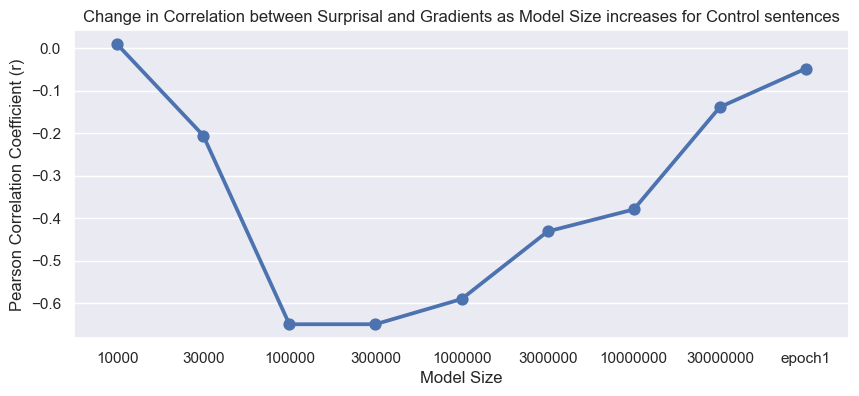

In [50]:
# Change plot size to display x-axis ticks more legible
sns.set_theme(rc={'figure.figsize':(10, 4)})

regression_data_df = pd.DataFrame(regression_data_df, columns=["Model Size", "Pearson Correlation Coefficient (r)"])

plt.figure()
sns.pointplot(data=regression_data_df, x="Model Size", y="Pearson Correlation Coefficient (r)")
plt.title("Change in Correlation between Surprisal and Gradients as Model Size increases for Control sentences")
regression_data_df

### Visualizing Correlations between Surprisals of Violation Sentences vs Control Sentences
We draw plots of a model's surprisal values for sentences with anomalies/violations against sentences without violations, then draw a final plot to show the change in Pearson Correlation Coefficient between the variables as the model grows in size.

<Figure size 600x600 with 0 Axes>

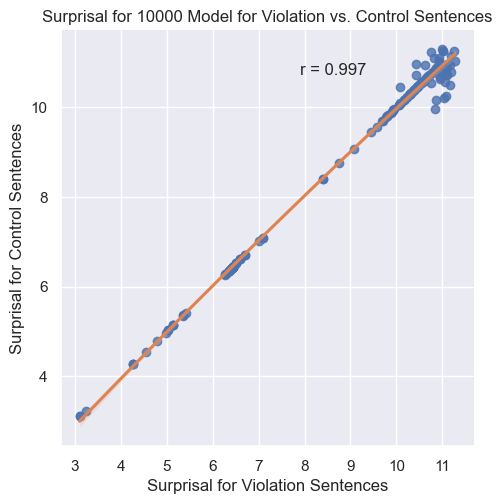

<Figure size 600x600 with 0 Axes>

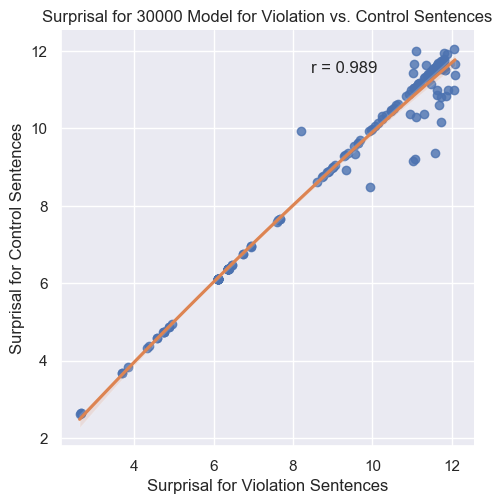

<Figure size 600x600 with 0 Axes>

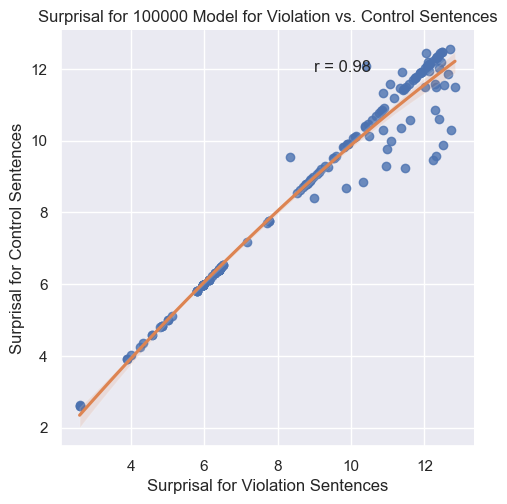

<Figure size 600x600 with 0 Axes>

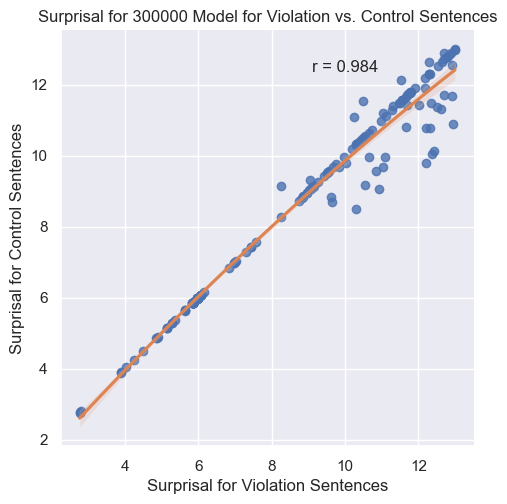

<Figure size 600x600 with 0 Axes>

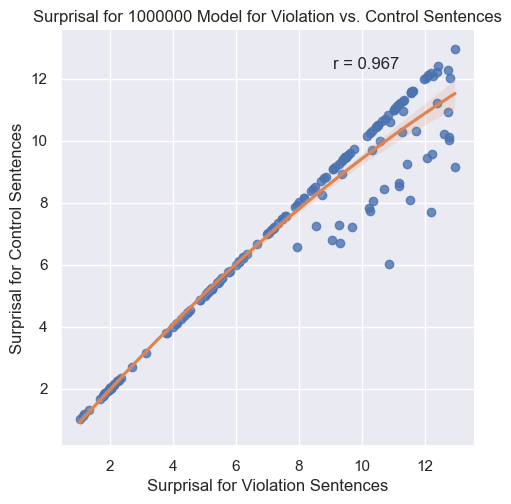

<Figure size 600x600 with 0 Axes>

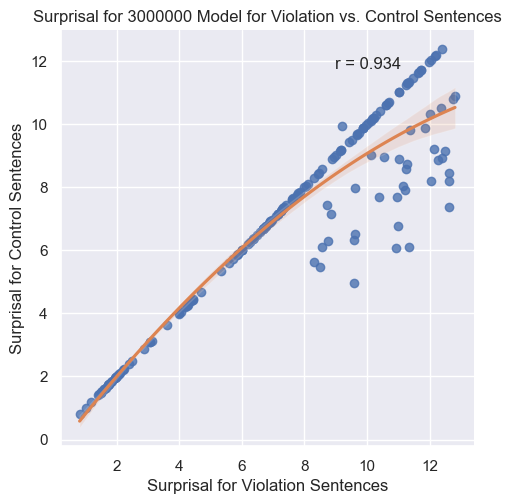

<Figure size 600x600 with 0 Axes>

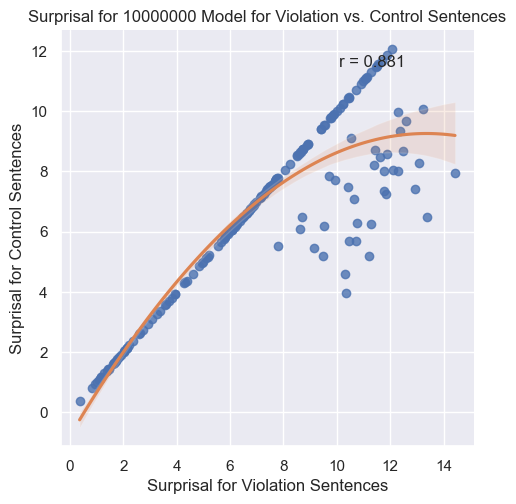

<Figure size 600x600 with 0 Axes>

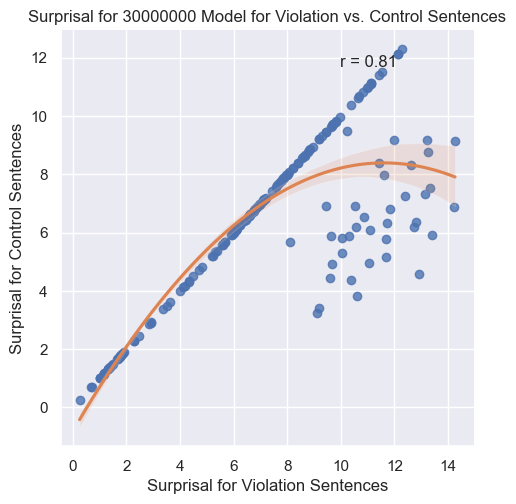

<Figure size 600x600 with 0 Axes>

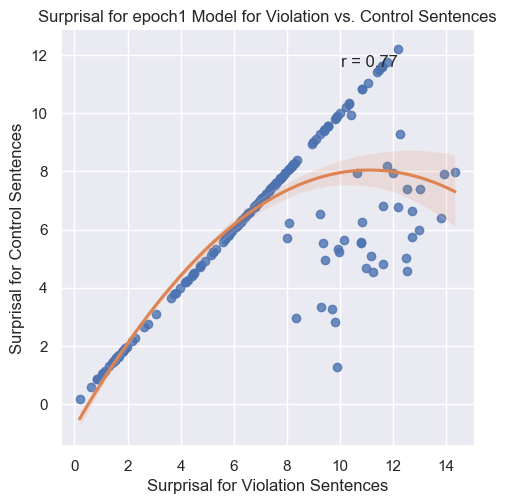

In [67]:
# Setting size of the plots 
sns.set_theme(rc={'figure.figsize':(6, 6)})

# Finding the columns with results of different model sizes
model_column_names_mask = violations_df.columns.str.contains("surp_*")
surprisal_columns_df = violations_df.loc[:, model_column_names_mask]

regression_data_df = []
# For every model size, visualize the correlation between surprisal values for sentences with and without anomalies
for column_name in surprisal_columns_df.columns:
    model_size_string = column_name[5:]
    
    surprisals_violations_vs_control_df = pd.concat([violations_df[column_name], control_df[column_name]], axis=1).dropna()
    surprisals_violations_vs_control_df.columns = [f"surp_{model_size_string}_violations", f"surp_{model_size_string}_control"]
    
    r_correlation = draw_lineplot(
        x_axis_name=f"surp_{model_size_string}_violations", 
        y_axis_name=f"surp_{model_size_string}_control", 
        df=surprisals_violations_vs_control_df,
        x_axis_label="Surprisal for Violation Sentences",
        y_axis_label="Surprisal for Control Sentences",
        title=f"Surprisal for {model_size_string} Model for Violation vs. Control Sentences"
    )
    
    plt.savefig(os.path.join(SAVED_IMAGES_PATH, "surprisal_violations_vs_control", f"{model_size_string}.png"), bbox_inches="tight")
    
    regression_data_df.append([model_size_string, r_correlation])

,Model Size,Pearson Correlation Coefficient (r)
0,10000,0.997241
1,30000,0.989076
2,100000,0.980166
3,300000,0.984090
4,1000000,0.966865
5,3000000,0.934007
6,10000000,0.881160
7,30000000,0.810222
8,epoch1,0.770059


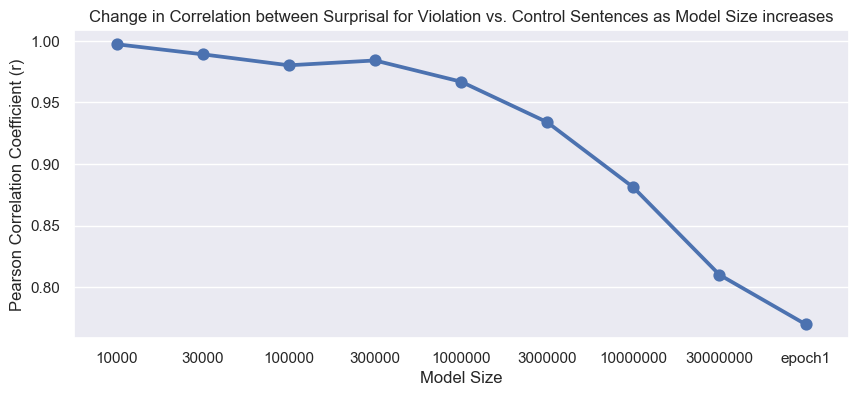

In [66]:
# Change plot size to display x-axis ticks more legible
sns.set_theme(rc={'figure.figsize':(10, 4)})

regression_data_df = pd.DataFrame(regression_data_df, columns=["Model Size", "Pearson Correlation Coefficient (r)"])

plt.figure()
plt.title("Change in Correlation between Surprisal for Violation vs. Control Sentences as Model Size increases")
sns.pointplot(data=regression_data_df, x="Model Size", y="Pearson Correlation Coefficient (r)")
regression_data_df

### Visualizing Correlations between Surprisals of Violation Sentences vs Control Sentences
We draw plots of a model's surprisal values for sentences with anomalies/violations against sentences without violations, then draw a final plot to show the change in Pearson Correlation Coefficient between the variables as the model grows in size.

<Figure size 600x600 with 0 Axes>

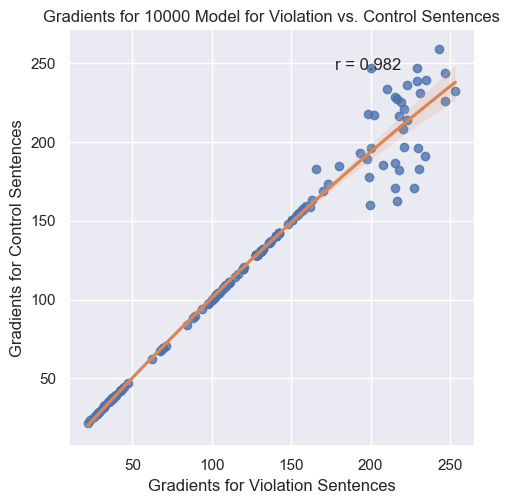

<Figure size 600x600 with 0 Axes>

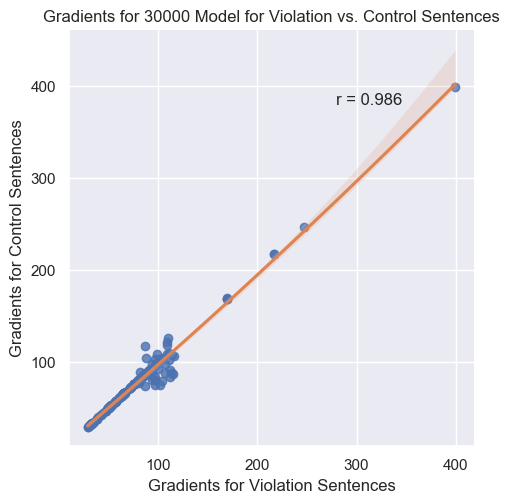

<Figure size 600x600 with 0 Axes>

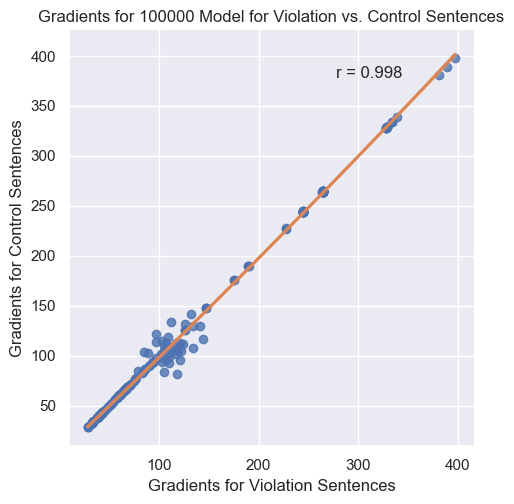

<Figure size 600x600 with 0 Axes>

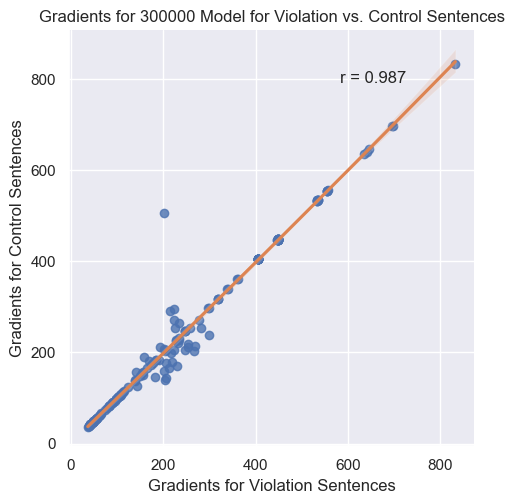

<Figure size 600x600 with 0 Axes>

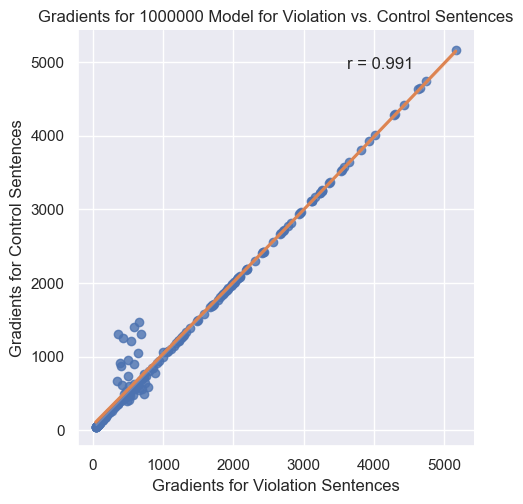

<Figure size 600x600 with 0 Axes>

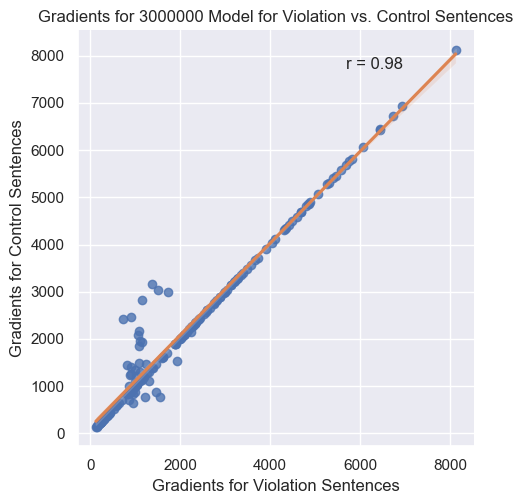

<Figure size 600x600 with 0 Axes>

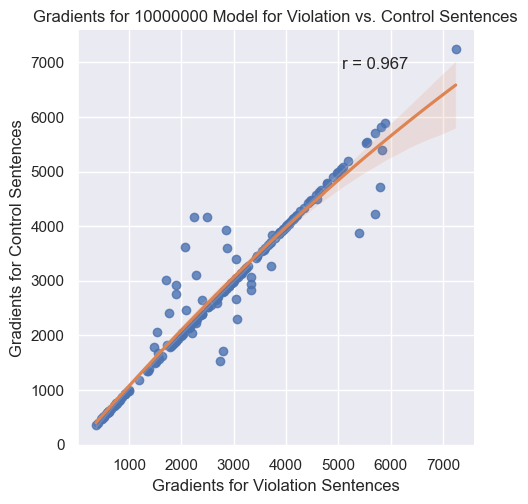

<Figure size 600x600 with 0 Axes>

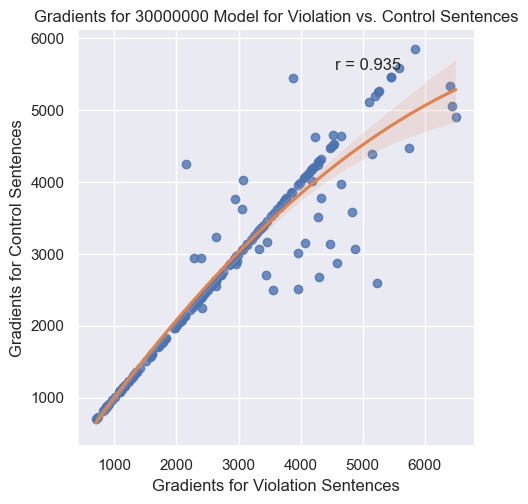

<Figure size 600x600 with 0 Axes>

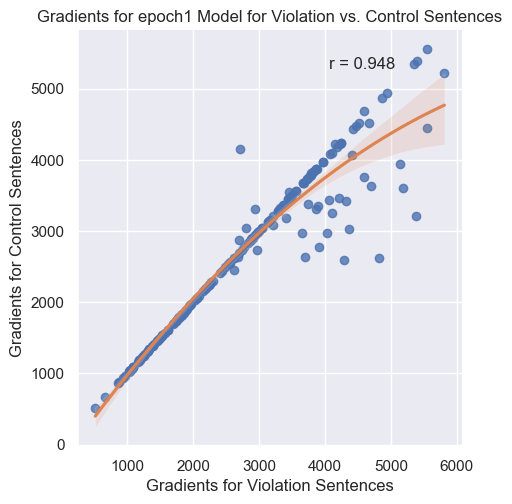

In [69]:
# Setting size of the plots 
sns.set_theme(rc={'figure.figsize':(6, 6)})

# Finding the columns with results of different model sizes
model_column_names_mask = violations_df.columns.str.contains("grad_*")
gradient_columns_df = violations_df.loc[:, model_column_names_mask]

regression_data_df = []
# For every model size, visualize the correlation between gradient values for sentences with and without anomalies
for column_name in gradient_columns_df.columns:
    model_size_string = column_name[5:]
    
    gradients_violations_vs_control_df = pd.concat([violations_df[column_name], control_df[column_name]], axis=1).dropna()
    gradients_violations_vs_control_df.columns = [f"grad_{model_size_string}_violations", f"grad_{model_size_string}_control"]
    
    r_correlation = draw_lineplot(
        x_axis_name=f"grad_{model_size_string}_violations", 
        y_axis_name=f"grad_{model_size_string}_control", 
        df=gradients_violations_vs_control_df,
        x_axis_label="Gradients for Violation Sentences",
        y_axis_label="Gradients for Control Sentences",
        title=f"Gradients for {model_size_string} Model for Violation vs. Control Sentences"
    )
    
    plt.savefig(os.path.join(SAVED_IMAGES_PATH, "gradients_violations_vs_control", f"{model_size_string}.png"), bbox_inches="tight")
    
    regression_data_df.append([model_size_string, r_correlation])

,Model Size,Pearson Correlation Coefficient (r)
0,10000,0.981745
1,30000,0.985546
2,100000,0.997756
3,300000,0.987428
4,1000000,0.991342
5,3000000,0.980152
6,10000000,0.967406
7,30000000,0.934947
8,epoch1,0.947965


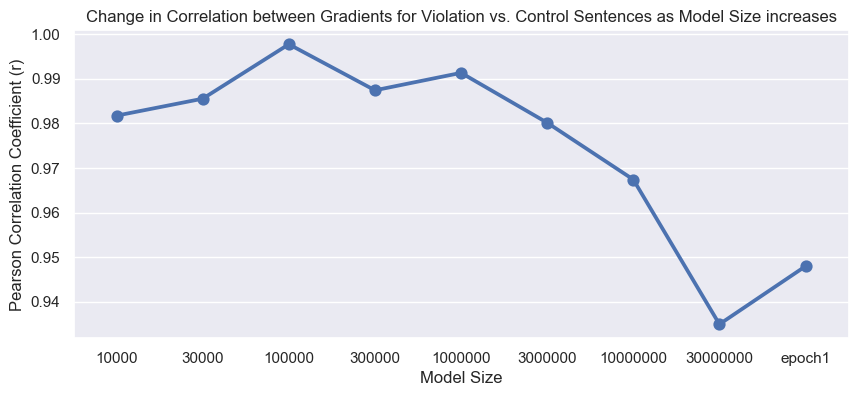

In [70]:
# Change plot size to display x-axis ticks more legible
sns.set_theme(rc={'figure.figsize':(10, 4)})

regression_data_df = pd.DataFrame(regression_data_df, columns=["Model Size", "Pearson Correlation Coefficient (r)"])

plt.figure()
plt.title("Change in Correlation between Gradients for Violation vs. Control Sentences as Model Size increases")
sns.pointplot(data=regression_data_df, x="Model Size", y="Pearson Correlation Coefficient (r)")
regression_data_df